In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [170]:
df = pd.read_csv('../dataset/raw_dataset.csv')

In [171]:
# Categorical columns
categorical_columns = [
    'genre', 'country', 'language', 'production_company',
]

# Numerical columns
numerical_columns = [
     'duration', 'avg_vote', 'votes', 'revenue_with_CPI', 'converted_budget', 
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination', 'writer_oscar_won', 
    'cast_oscar_nomination', 'cast_oscar_won', 'dir_globe_nomination', 'dir_globe_won', 'cast_globe_nomination', 
   'cast_globe_won','BAFTA_act_nom','BAFTA_act_won','BAFTA_dir_nom','BAFTA_dir_won',
    'BAFTA_writer_nom','BAFTA_writer_won', 'dir_emmy_nom','dir_emmy_won','writer_emmy_won',
    'writer_emmy_nom','act_emmy_nom','act_emmy_won'
    #'actors_films_before', 'director_films_before', 'writers_films_before'
]


categorical_df = df[categorical_columns]
numerical_df = df[numerical_columns]

df=df[numerical_columns+categorical_columns]
print("Categorical DataFrame:")
print(categorical_df.head())

print("\nNumerical DataFrame:")
print(numerical_df.head())


Categorical DataFrame:
                 genre country language  \
0         Crime, Drama     USA  English   
1                Drama     USA  English   
2  Drama, History, War     USA  English   
3                Drama     USA  English   
4     Adventure, Crime  France   French   

                                 production_company  
0  Independent Moving Pictures Co. of America (IMP)  
1               Jesse L. Lasky Feature Play Company  
2                                  Kay-Bee Pictures  
3                            Fine Arts Film Company  
4             Société des Etablissements L. Gaumont  

Numerical DataFrame:
   duration  avg_vote  votes  revenue_with_CPI  converted_budget  \
0      88.0       6.1  527.0        55484317.0          175700.3   
1      59.0       6.4  859.0       331523495.5         3013850.0   
2      77.0       6.1  218.0         4139975.0          521727.6   
3      50.0       4.6  554.0       223938744.3         5598468.6   
4     300.0       7.4  814.0    

In [172]:
df.isna().sum(axis=0)

duration                     0
avg_vote                     0
votes                        0
revenue_with_CPI             0
converted_budget           119
dir_oscar_nomination         0
dir_oscar_won                0
writer_oscar_nomination      0
writer_oscar_won             0
cast_oscar_nomination        0
cast_oscar_won               0
dir_globe_nomination         0
dir_globe_won                0
cast_globe_nomination        0
cast_globe_won               0
BAFTA_act_nom                0
BAFTA_act_won                0
BAFTA_dir_nom                0
BAFTA_dir_won                0
BAFTA_writer_nom             0
BAFTA_writer_won             0
dir_emmy_nom                 0
dir_emmy_won                 0
writer_emmy_won              0
writer_emmy_nom              0
act_emmy_nom                 0
act_emmy_won                 0
genre                        0
country                      5
language                   106
production_company         629
dtype: int64

# Budget
Remove rows with missing values: budget

In [173]:
df_cleaned = df.dropna(subset=['converted_budget'])
print(df.shape)
print(df_cleaned.shape)
print(f'Percentage of lost tuples: ', (1- len(df_cleaned)/len(df))*100)

(20825, 31)
(20706, 31)
Percentage of lost tuples:  0.5714285714285672


# Country and Language
1. Remove rows w/o both country and language
2. Handling language single value

1. Remove rows w/o both country and language

In [174]:
df_cleaned = df_cleaned.dropna(subset=['country', 'language'], how='all')

2. Handling language single value

In [175]:
#only first value of column
# e.g. Life is beautiful: italian, deutch, francois -> italian
df_cleaned['language'] = df_cleaned['language'].str.split(', ').str[0]
df_cleaned['country'] = df_cleaned['country'].str.split(', ').str[0]

Distribution of language values mantaining only top ones

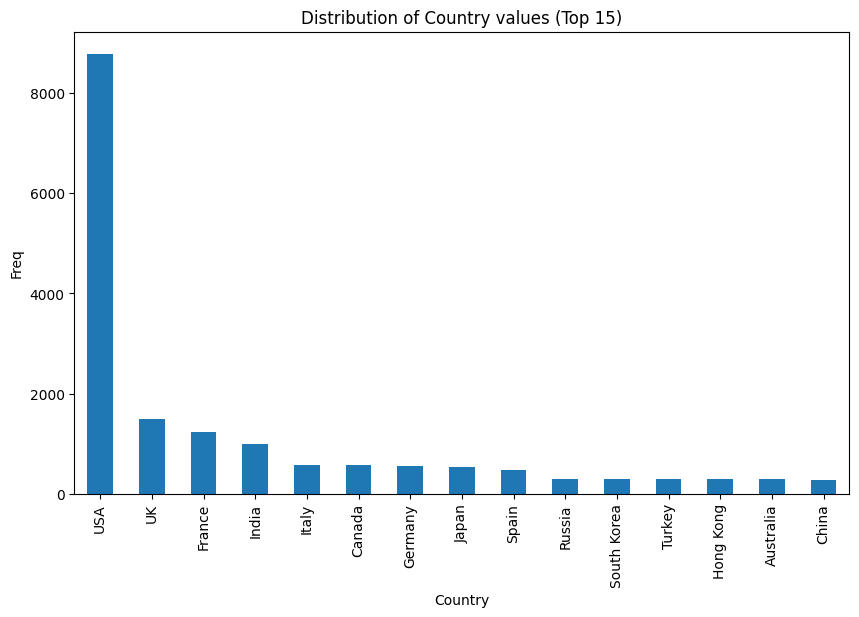

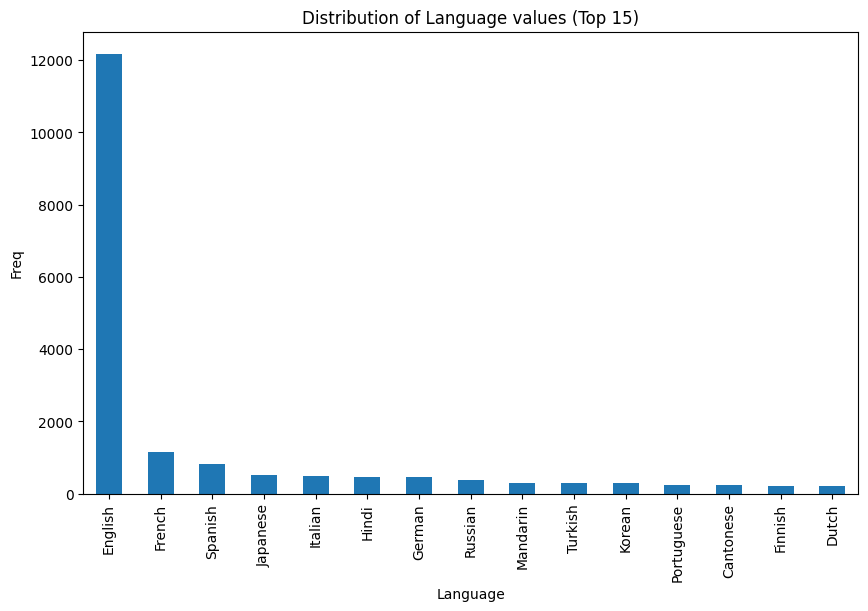

In [176]:
top_country_values = df_cleaned['country'].value_counts().head(15)
top_language_values = df_cleaned['language'].value_counts().head(15)
#Gr 1
plt.figure(figsize=(10, 6))
top_country_values.plot(kind='bar')
plt.title('Distribution of Country values (Top 15)')
plt.xlabel('Country')
plt.ylabel('Freq')
plt.show()
# Gr2
plt.figure(figsize=(10, 6))
top_language_values.plot(kind='bar')
plt.title('Distribution of Language values (Top 15)')
plt.xlabel('Language')
plt.ylabel('Freq')
plt.show()

In [177]:
# most freq values 15
other_languages = df_cleaned['language'][~df_cleaned['language'].isin(top_language_values.index)]
num_other_languages = len(other_languages)
print("Rows w/o language in top 15:", num_other_languages)

other_countries = df_cleaned['country'][~df_cleaned['country'].isin(top_country_values.index)]
num_other_countries = len(other_countries)
print("Rows w/o country in top 15:", num_other_countries)


Rows w/o language in top 15: 2489
Rows w/o country in top 15: 3718


In [178]:
#count values
language_counts = df_cleaned['language'].value_counts()
country_counts = df_cleaned['country'].value_counts()

top_languages = language_counts.head(15).index
top_countries = country_counts.head(15).index

df_cleaned.loc[~df_cleaned['language'].isin(top_languages), 'language'] = 'Other'
df_cleaned.loc[~df_cleaned['country'].isin(top_countries), 'country'] = 'Other'

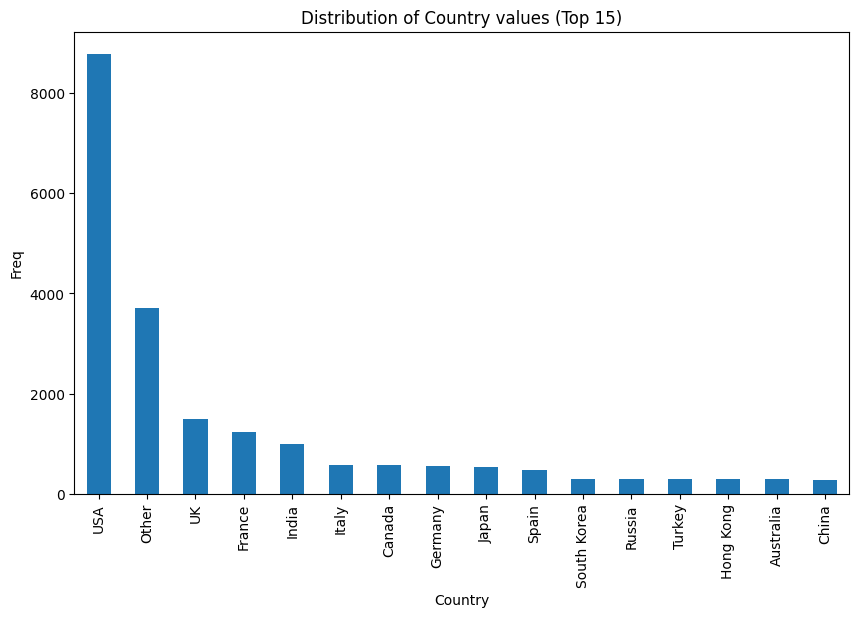

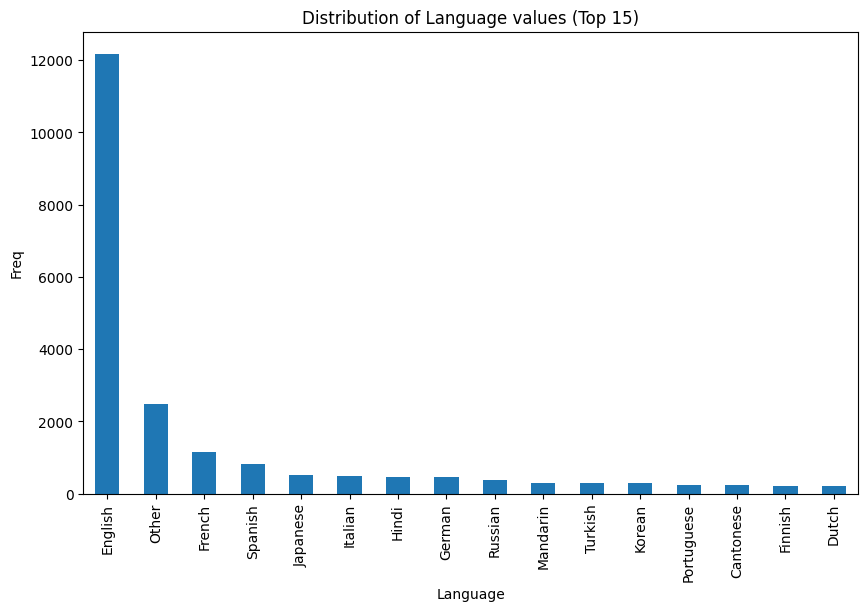

In [179]:
# Gr1
plt.figure(figsize=(10, 6))
df_cleaned['country'].value_counts().plot(kind='bar')
plt.title('Distribution of Country values (Top 15)')
plt.xlabel('Country')
plt.ylabel('Freq')
plt.show()
# Gr2
plt.figure(figsize=(10, 6))
df_cleaned['language'].value_counts().plot(kind='bar')
plt.title('Distribution of Language values (Top 15)')
plt.xlabel('Language')
plt.ylabel('Freq')
plt.show()

# Production Company

In [180]:
production_counts = df_cleaned['production_company'].value_counts()

# txt append file 4 exploring
with open('production_company_counts.txt', 'w') as file:
    for company, count in production_counts.items():
        file.write(f'{company}: {count}\n')

_Universal_

In [181]:
keywords = ['universal', 'amblin', 'dreamworks', ' universal', ' amblin', ' Dreamworks', 'universal ', 'amblin ', ' Dreamworks ', ' universal ', ' amblin ', ' dreamworks ']
exact_matches = [
    'Focus Films', 'Focus Features', 'Illumination Entertainment',
    'Illuminations Films', 'Universal International Pictures (UI)', 'Big Idea',
    'Bullwinkle Studios', 'DreamWorks', 'DreamWorks Animation',
    'Carnival Film & Television', 'Polygram Filmed Entertainment',
    'PolyGram Filmed Entertainment', 'Polygram Pictures', 'PolyGram Film Productions BV',
    ' Focus Films', ' Focus Features', ' Illumination Entertainment',
    ' Illuminations Films', ' Universal International Pictures (UI)', ' Big Idea',
    ' Bullwinkle Studios', ' DreamWorks', ' DreamWorks Animation',
    ' Carnival Film & Television', ' Polygram Filmed Entertainment',
    ' PolyGram Filmed Entertainment', ' Polygram Pictures', ' PolyGram Film Productions BV', 
    'Focus Films ', 'Focus Features ', 'Illumination Entertainment ',
    'Illuminations Films ', 'Universal International Pictures (UI) ', 'Big Idea ',
    'Bullwinkle Studios ', 'DreamWorks ', 'DreamWorks Animation ',
    'Carnival Film & Television ', 'Polygram Filmed Entertainment ',
    'PolyGram Filmed Entertainment ', 'Polygram Pictures ', 'PolyGram Film Productions BV '
]

def replace_company_name(company):
    if pd.isna(company):
        return company 
    company_lower = str(company).lower()  
    if any(keyword in company_lower for keyword in keywords):
        return 'Universal'
    if company in exact_matches:
        return 'Universal'
    return company
df_cleaned['production_company'] = df_cleaned['production_company'].apply(replace_company_name)
"""universal_count = (df_cleaned['production_company'] == 'Universal').sum()
print(f"'Universal': {universal_count}")"""


'universal_count = (df_cleaned[\'production_company\'] == \'Universal\').sum()\nprint(f"\'Universal\': {universal_count}")'

_Paramount_

In [182]:
paramount_keywords = ['paramount', 'cbs']
paramount_exact_matches = ['Paramount', 'CBS', 'Miramax', 'Nickelodeon Movies', 'Nickel Odeon',
                           'Republic Pictures (I)', 'Republic Pictures (II)',
                           'Republic Pictures Corporation (I)', 'MTV Films',
                           'BET Films', 'BET Pictures',
                           'Awesomeness Films', 'Viacom18 Motion Pictures']
def replace_company_name(company):
    if pd.isna(company):
        return company  
    company_lower = str(company).lower()  
    if any(keyword in company_lower for keyword in paramount_keywords):
        return 'Paramount'
    if company in paramount_exact_matches:
        return 'Paramount'
    return company

df_cleaned['production_company'] = df_cleaned['production_company'].apply(replace_company_name)

"""paramount_count = (df_cleaned['production_company'] == 'Paramount').sum()
print(f"'Paramount': {paramount_count}")"""

'paramount_count = (df_cleaned[\'production_company\'] == \'Paramount\').sum()\nprint(f"\'Paramount\': {paramount_count}")'

_Warner_

In [183]:
warner_keywords = ['Warner']
warner_exact_matches = ['HBO', 'New Line Cinema', 'Spyglass Entertainment', 'Rooster Teeth Productions',
                           'DC Entertainment', 'DC Medias', 'DC Comics', 'Cartoon Network Studios',
                           'Richard Williams Productions', 'Derick Williams Productions', 
                           'Hanna-Barbera Productions', 'Alloy Entertainment', 'Castle Rock Entertainment',
                           'Turner Pictures (I)', 'Discovery Films UK', 'The Weinstein Company']
def mod_and_count(df_cleaned, keywords, exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        if any(keyword.lower() in str(row['production_company']).lower() for keyword in keywords):
            df_cleaned.at[i, 'production_company'] = 'Warner'
            mods_count += 1
        elif row['production_company'] in exact_matches:
            df_cleaned.at[i, 'production_company'] = 'Warner'
            mods_count += 1
    return mods_count

mods = mod_and_count(df_cleaned, warner_keywords, warner_exact_matches)
numero_righe_warner = (df_cleaned['production_company'] == 'Warner').sum()


_20th Century Fox_

In [184]:
twenty_exact_matches = ['ESPN Films',
 '20th Century Fox',
 '20th Century Fox Argentina',
 '20th Century Fox Television',
 '20th Century Pictures',
 'Twentieth Century Fox',
 'Twentieth Century Fox Animation',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'Fox Atomic',
 'Fox International Productions (FIP)',
 'Fox Film Corporation',
 'Fox STAR Studios',
 'Fox Digital Studios',
 'Fox Family Channel',
 'Fox Filmes do Brasil',
 '21st Century Film Corporation',
 '21st Century 3D',
 '21st Century Films',
 '21st Century Productions UK',
 '21st Century Film Production',
 'ESPN Films',
 'Lucasfilm',
 'Lucasfilm Animation',
 'Freeform',
 'New World Pictures',
 'New World Entertainment Films',
 'New World Films', 'Regency Enterprises']

def mod_and_count(df_cleaned, twenty_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in keywords):
            df_cleaned.at[i, 'production_company'] = 'Twentieth Century Fox'
            mods_count += 1"""
        if row['production_company'] in twenty_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'Twentieth Century Fox'
            mods_count += 1
    return mods_count

# Esegui le modifiche e contali
mods = mod_and_count(df_cleaned, twenty_exact_matches)


_Disney_

In [185]:
disney_keywords = ['Disney']

# Lista delle corrispondenze esatte
disney_exact_matches = [
    'Marvel Entertainment', 'Marvel Enterprises', 'Marvel Studios', 'Pixar Animation Studios', 'Touchstone Pictures',
    'Hollywood Pictures'
]

# Funzione per contare le righe che soddisfano le condizioni specificate
def mod_and_count(df_cleaned, disney_keywords, disney_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        if any(keyword.lower() in str(row['production_company']).lower() for keyword in disney_keywords):
            df_cleaned.at[i, 'production_company'] = 'Disney'
            mods_count += 1
        elif row['production_company'] in disney_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'Disney'
            mods_count += 1
    return mods_count

# Esegui le modifiche e contali
mod_and_count(df_cleaned, disney_keywords, disney_exact_matches)

344

_Sony_

In [186]:
sony_keywords = ['sony', 'tristar', 'columbia']
sony_exact_matches = [
     'Screen Gems',
     'Stage 6 Films',
     'Affirm Films',
     'Ghost Film Pictures',
     'Ghost Pictures',
     'Madhouse',
     'Toei Company',
     'Toei Animation',
     'Toei',
     'Toei Tokyo',
     'Toei Video Company',
     'Destination Films',
     'Left Bank Pictures',
     'Revolution Studios',
     'Revolution Films',
]

def mod_and_count(df_cleaned, sony_keywords, sony_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        if any(keyword.lower() in str(row['production_company']).lower() for keyword in sony_keywords):
            df_cleaned.at[i, 'production_company'] = 'Sony'
            mods_count += 1
        elif row['production_company'] in sony_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'Sony'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, sony_keywords, sony_exact_matches)

620

_MGM_

In [187]:
MGM_exact_matches = [
     'Metro-Goldwyn-Mayer (MGM)',
     'Metro Films',
     'Metro Pictures Corporation',
     'Metro Communications',
     'Monogram Pictures',
     'Cannon Group',
     'Cannon Films',
     'The Cannon Group',
     'Cannon Pictures',
     'Cannon International',
     'Cannon Entertainment',
     'The Samuel Goldwyn Company',
     'Samuel Goldwyn Films'
]

def mod_and_count(df_cleaned, MGM_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in sony_keywords):
            df_cleaned.at[i, 'production_company'] = 'MGM'
            mods_count += 1"""
        if row['production_company'] in MGM_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'MGM'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, MGM_exact_matches)

265

_United Artists_

In [188]:
UA_exact_matches = [
     'United Artists',
     'United Artists Film Corporation',
     'United Artists Pictures', 'United Arists'
]
def mod_and_count(df_cleaned, UA_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in sony_keywords):
            df_cleaned.at[i, 'production_company'] = 'United Artists'
            mods_count += 1"""
        if row['production_company'] in UA_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'United Artists'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, UA_exact_matches)

34

_RKO_

In [189]:
RKO_exact_matches = [
     'RKO Radio Pictures',
     'RKO Pictures'
]

# Funzione per contare le righe che soddisfano le condizioni specificate
def mod_and_count(df_cleaned, RKO_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in sony_keywords):
            df_cleaned.at[i, 'production_company'] = 'United Artists'
            mods_count += 1"""
        if row['production_company'] in RKO_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'RKO'
            mods_count += 1
    return mods_count
mod_and_count(df_cleaned, RKO_exact_matches)

35

_Lionsgate_

In [190]:
LG_exact_matches = [
     'Lionsgate',
     'Lions Gate Films',
     'Lions Gate Entertainment',
     'Lionsgate Premiere',
     'Lionsgate UK',
     'Lions Gate International',
     'Lions Gate Family Entertainment',
     'Summit Entertainment',
     'Summit Premiere',
     '3 Arts Entertainment',
     'Entertainment One',
     'Entertainment One India Ltd.',
     'Good Universe',
     'Grindstone Entertainment Group',
     'Pantelion Films',
     'Roadside Attractions',
     'Spyglass Entertainment',
     'Artisan Entertainment',
     'Overture Films'
]

def mod_and_count(df_cleaned, LG_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in LG_keywords):
            df_cleaned.at[i, 'production_company'] = 'United Artists'
            mods_count += 1"""
        if row['production_company'] in LG_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'Lionsgate'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, LG_exact_matches)

193

_Amazon_

In [191]:
AMZ_exact_matches = [
     'Amazon Studios',
     'Amazon Prime Video',
     'Orion Pictures',
     'LightWorkers Media',
     'American International Pictures (AIP)',
     'American Independent Productions',
]

def mod_and_count(df_cleaned, AMZ_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in LG_keywords):
            df_cleaned.at[i, 'production_company'] = 'United Artists'
            mods_count += 1"""
        if row['production_company'] in AMZ_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'Amazon'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, AMZ_exact_matches)

77

_STX_

In [192]:
STX_exact_matches = [
     'STX Films',
     'STX Entertainment'
]

def mod_and_count(df_cleaned, STX_exact_matches):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        """if any(keyword.lower() in str(row['production_company']).lower() for keyword in LG_keywords):
            df_cleaned.at[i, 'production_company'] = 'United Artists'
            mods_count += 1"""
        if row['production_company'] in STX_exact_matches:
            df_cleaned.at[i, 'production_company'] = 'STX'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, STX_exact_matches)


8

_De Laurentiis_

In [193]:
Dino_keywords = ['De Laurentiis']

def mod_and_count(df_cleaned, Dino_keywords):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        if any(keyword.lower() in str(row['production_company']).lower() for keyword in Dino_keywords):
            df_cleaned.at[i, 'production_company'] = 'De Laurentiis'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, Dino_keywords)

46

_Medusa films_

In [194]:
Dino_keywords = ['Medusa', 'Berlusconi', 'Cecchi']

def mod_and_count(df_cleaned, Dino_keywords):
    mods_count = 0
    for i, row in df_cleaned.iterrows():
        if any(keyword.lower() in str(row['production_company']).lower() for keyword in Dino_keywords):
            df_cleaned.at[i, 'production_company'] = 'Medusa'
            mods_count += 1
    return mods_count

mod_and_count(df_cleaned, Dino_keywords)

36

In [195]:
df_cleaned.to_csv('../dataset/complete_raw_dataset.csv', index=False)

In [196]:
"""df = pd.read_csv('../dataset/complete_raw_dataset.csv')

production_counts = df['production_company'].value_counts()

with open('production_company_counts.txt', 'w') as file:
    for company, count in production_counts.items():
        file.write(f'{company}: {count}\n')"""

# Date conversion

# One hot encoding

In [200]:
"""companies_counts = df_cleaned['production_company'].value_counts()
print(companies_counts)
top_languages = language_counts.head(22).index
df_cleaned.loc[~df_cleaned['production_company'].isin(top_countries), 'production_company'] = 'Other'"""

production_company
Warner                     679
Universal                  622
Sony                       620
Paramount                  509
Twentieth Century Fox      499
                          ... 
State Street Pictures        1
Roc Media                    1
Tag Entertainment            1
Graveyard Filmworks          1
Thomas Thiruvalla Films      1
Name: count, Length: 9876, dtype: int64


"top_languages = language_counts.head(15).index\ndf_cleaned.loc[~df_cleaned['country'].isin(top_countries), 'country'] = 'Other'"

In [ ]:
def multivalue_one_hot(df, column):
    s = df[column].str.get_dummies(sep=', ')
    return df.join(s.add_prefix(column + ''))
df_selected = multi_value_one_hot(df_selected, 'genre')